#  Q-AGGREGATION

Define the Q-functional : 

\begin{align}
\begin{split}
Q(\theta) &= (1-\nu) R_n(f_\theta) &+ \nu \sum_{j=1} \theta_j R_n(f_j) \\
&= (1-\nu) \frac{1}{n} \sum_{i=1}^n (y_i - f_\theta(x_i))^2 &+ \nu \sum_{j=1}^M \theta_j \frac{1}{n} \sum_{i=1}^n (y_i - f_j(x_i))^2 \\
&= (1-\nu) \frac{1}{n} \sum_{i=1}^n (y_i - \sum_{j=1}^M \theta_j f_j(x_i))^2 &+ \nu \sum_{j=1}^M \theta_j \frac{1}{n} \sum_{i=1}^n (y_i - f_j(x_i))^2\end{split}
\end{align}

The Q-aggregate estimator verifies :

\begin{align}
\theta^Q = \arg \min_{\theta \in \Theta} Q(\theta)
\end{align}


We can compute the partial derivatives of the Q-functional :

\begin{align}
\begin{split}
\frac{\partial}{\partial \theta_l} Q(\theta) &\propto (1-\nu) \sum_{i=1}^n -2 f_l(x_i) \left(y_i - \sum_{j=1}^M \lambda_j f_j(x_i)\right) + \nu \sum_{i=1}^n (y_i - f_l(x_i))^2 \\
&\propto \sum_{i=1}^n - 2 (1-\nu) f_l(x_i) \left(y_i - \sum_{j=1}^M \lambda_j f_j(x_i)\right) + \nu (y_i - f_l(x_i))^2
\end{split}
\end{align}

and use greedy Frank-Wolfe algorithm as in Rigollet et al.

We have shown that the performance of the algorithm deteriorates as we add outliers in the dataset.

We thus introduced a MOM version of the Q-functional :

\begin{align}
Q^{MOM}(\theta) = (1-\nu) MOM_K (f(\theta)) + \nu \sum_{j=1}^M \theta_j MOM_K(f(\theta_j)) 
\end{align}

We implemented a MOM version of the greedy Frank Wolfe algorithm (similar to the MOM version of gradient descent, i.e. at each step we randomly constitute blocks, we find the block which has the median mean and proceed to a normal step of the algorithm with the data from this median block). This does not seem to work.

The next idea is to try IP methods to solve this problem. Greedy FW had the advantage of returning a sparse solution, however it seems that, since once a function is selected, it is neither removed, each step is "too" important.

In [1]:
from sklearn.metrics import mean_squared_error

from sklearn.datasets import make_regression
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
%pylab inline

from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


# Computations for IP method

Objective function : 

\begin{align}
f_0(\theta) = \frac{(1-\nu)}{|B_0^*|} \sum_{i \in B_0^*} \left(y_i - \sum_{j=1}^M \theta_j f_j(x_i)\right)^2 + \nu \sum_{j=1}^M \theta_j \frac{1}{|B_j^*|}\sum_{i \in B_j^*} \left(y_i - f_j(x_i)\right)^2 
\end{align}

The first derivatives are given by :

\begin{align}
\frac{\partial}{\partial \theta_l} f_0(\theta) = \frac{(1-\nu)}{|B_0^*|} \sum_{i \in B_0^*} -2 f_l(x_i) \left(y_i - \sum_{j=1}^M \theta_j f_j(x_i)\right) + \nu \frac{1}{|B_l^*|}\sum_{i \in B_l^*} \left(y_i - f_l(x_i)\right)^2, \quad  l=1, \dots, M
\end{align}

The second derivatives are given by, 
\begin{align}
\frac{\partial^2}{\partial \theta_l \partial \theta_m} f_0(\theta) = \frac{2(1-\nu)}{|B_0^*|} \sum_{i \in B_0^*}f_l(x_i)f_m(x_i) \quad l, m=1, \dots, M
\end{align}

In [25]:
class Q_aggregation():
    
    def __init__(self, predictors, nu=0.5, beta=0, trained_predictors=False):
        """
        predictors : list of predictors ()
        """
        self.predictors = predictors # list of predictors
        self.M = len(predictors) # number of predictors
        self.nu = nu # interpolation coefficient
        self.beta = beta # temperature parameter for prior weights
        self.trained_predictors = False # True for already trained predictors
    
    def set_prior_weights(self, prior_weights):
        """
        Set prior weights (see the article for meaning of such quantities)
        """
        self.pi = prior_weights
        
    def train_predictors(self, X, y):
        self.predictors = [predictor.fit(X, y) for predictor in self.predictors] # trained_predictors
        self.trained_predictors = True
    
    def Q(self, theta, X, y):
        n, p = X.shape
        predictions = np.zeros((n, self.M))
        
        for m, predictor in enumerate(self.predictors):
            predictions[:, m] = predictor.predict(X)
        
        if theta.any()>0:
            MSE_theta = mean_squared_error(np.average(predictions, axis=1, weights=theta), y)
        else:
            MSE_theta = mean_squared_error(np.zeros(y.shape), y)
        
        Q = (1-self.nu)*MSE_theta + self.nu*np.sum([theta[m]*mean_squared_error(predictions[:, m], y) 
                                                    for m in range(self.M)])
        return Q
        
    def NablaQ(self, theta, X, y):
        n, p = X.shape
        
        predictions = np.zeros((n, self.M))
        
        for m, predictor in enumerate(self.predictors):
            predictions[:, m] = predictor.predict(X)
        
        derivatives = np.zeros(self.M)
        for j in range(self.M):
            for i in range(n):
                if theta.any()>0:
                    derivatives[j] += (-2*(1-self.nu)*predictions[i, j]*(y[i] - np.average(predictions[i, :], weights=theta))
                                      + self.nu * (y[i] - predictions[i, j])**2)
                else:
                    derivatives[j] += (-2*(1-self.nu)*predictions[i, j]*y[i]
                                      + self.nu * (y[i] - predictions[i, j])**2)
        return derivatives
    
    def GMA_0(self, X, y, K):
        
        theta = np.zeros(self.M)
        
        for k in range(1, K):
            
            alpha = 2/(k+1)
            
            J = np.argmin([self.Q(theta, X, y) + alpha*(np.eye(self.M)[:, m] - theta) for m in range(self.M)])
            
            # option-1
            theta = theta + alpha*(np.eye(self.M)[:, J] - theta)
            
        self.theta = theta
        
    def GMA_1(self, X, y, K):
        """
        X : 2D numpy array, design matrix
        y : 1D numpy array, target vector
        K : integer, number of iterations
        """
        theta = np.zeros(self.M)
        
        for k in range(1, K):            
            alpha = 2/(k+1)
                        
            J = np.argmin(self.NablaQ(theta, X, y))
                        
            # option-1
            theta = theta + alpha*(np.eye(self.M)[:, J] - theta)
            
        self.theta = theta
    
    def NablaQ_MOM(self, theta, predictions, y, aggregate_median_block_idx, individual_median_block_idx):
                        
        derivatives = np.zeros(self.M)
        
        for j in range(self.M):
            for i in aggregate_median_block_idx:
                if theta.any()>0:
                    derivatives[j] += (-2*(1-self.nu)*predictions[i, j]*
                                       (y[i] - np.average(predictions[i, :], weights=theta)))/30
                else:
                    derivatives[j] += (-2*(1-self.nu)*predictions[i, j]*y[i])/30
                                           
            for i in individual_median_block_idx[j, :]:
                derivatives[j] += (self.nu * (y[i] - predictions[i, j])**2)/30

        return derivatives
    
    def split_into_blocks(self, predictions, theta, n_blocks):
        n = predictions.shape[0]
        
        # MOM risk for aggregate estimator
        
        # split data into n_blocks
        blocks_idx = np.split(np.random.permutation(n), n_blocks)
        
        if theta.any()>0:
            aggregate_pred = np.average(predictions, axis=1, weights = theta)
        else:
            aggregate_pred = np.zeros(n)
        
        # compute empirical risk on each block
        block_risks = [mean_squared_error(aggregate_pred[block], y[block]) 
                       for block in blocks_idx]
        # Index of median block
        aggregate_median_block_idx = blocks_idx[numpy.argsort(block_risks)[n_blocks//2]]

        individual_median_block_idx = np.zeros((self.M, len(blocks_idx[0])))

        # MOM risk for each individual estimator
        for m, predictor in enumerate(self.predictors):
            # split data into n_blocks
            blocks_idx = np.split(np.random.permutation(n), n_blocks)

            block_risks = [mean_squared_error(predictions[block, m], y[block]) 
                       for block in blocks_idx]

            individual_median_block_idx[m,:] = blocks_idx[numpy.argsort(block_risks)[n_blocks//2]]                                           

        individual_median_block_idx = individual_median_block_idx.astype(int)
        
        return aggregate_median_block_idx, individual_median_block_idx

        
    def GMA_1_MOM(self, X, y, K, n_blocks):
        theta = np.zeros(self.M)
        
        n, d = X.shape
                
        predictions = self.compute_individual_predictions(X)
            
        for k in range(1, K):
            alpha = 2/(k+1)
            
            aggregate_median_block_idx, individual_median_block_idx = self.split_into_blocks(predictions, theta, n_blocks) 
            
            J = np.argmin(self.NablaQ_MOM(theta, predictions, y, aggregate_median_block_idx, individual_median_block_idx))

            theta = theta + alpha*(np.eye(self.M)[:, J] - theta)
            
        self.theta = theta
        
    # Interior point method

    def gradient_Q(self, theta, y, F, B_star):
        """
        Compute gradient of the Q-functional

        Inputs :
        theta: 1D array, current probability vector
        y: 1D array, target vector
        F: 2D array of shape (n_samples, n_predictors), prediction matrix
        B_star: 2D array of shape (n_obs_per_block, n_predictors+1), indexes of obs in median blocks
        """
        
        n, M = F.shape
        grad = np.zeros(M)
        
        # indexes of aggregate risk median block
        B_0_star = B_star[:, 0]

        n_samples_per_block = len(B_0_star) # =30 OK
                
        aggregate_error = y[B_0_star] - np.dot(F[B_0_star, :], theta)
        
        for l in range(M):
            B_l_star = B_star[:, l+1]
            
            # to account for the fact that the first column correponds to indexes of obs from median aggregate block
            
            quadratic_term = np.sum(np.multiply(F[B_0_star, l], aggregate_error))
            linear_term = np.linalg.norm(y[B_l_star] - F[B_l_star, l], ord=2)**2  
            
            grad[l] = -2*(1-self.nu)/n_samples_per_block*quadratic_term + self.nu/n_samples_per_block*linear_term

        return grad

    def hessian_Q(self, F, B_star):
        """
        Compute Hessian of the Q-functional

        Inputs :
        F: 2D array of shape (n, M), prediction matrix
        B_star: 2D array of shape (n_obs_per_block, n_predictors+1), indexes of obs in median blocks
        """
        B_0_star = B_star[:, 0]
        
        H = 2*(1-self.nu)/len(B_0_star)*np.dot(F[B_0_star, :].T, F[B_0_star, :])
                
        return H
        
    def gradient_phi(self, theta):
        """
        Compute gradient of the barrier function
        """
        return -np.reciprocal(theta) # np.reciprocal returns coordinate-wise inverse
        
    def hessian_phi(self, theta):
        """
        Compute Hessian of the barrier function
        """
        return np.diag(np.reciprocal(theta**2))
    
    def KKT_system(self, grad_theta, hessian_theta):
        """
        Compute KKT matrix and KKT "bias"
        
        Inputs :
        theta: 1D array, aggregation parameter 
        grad_theta: gradient of the full objective (i.e. including barrier function) w.r.t. theta
        hessian_theta: Hessian of the full objective (i.e. including barrier function) w.r.t. theta
        """
        # upper part of KKT matrix ()
        upper_left = hessian_theta # shape OK : (32, 32) 
        upper_right = np.ones(self.M).T # shape OK : (32, )        
        upper = np.column_stack((upper_left, upper_right)) # shape OK : (32, 33)
            
        # lower part of KKT matrix (Lagrange multiplier eq)
        lower_left = np.ones(self.M)
        lower = np.concatenate((lower_left, np.zeros(1)))
        
        # form full KKT matrix
        KKT_matrix = np.row_stack((upper, lower)) # shape OK : (33, 33)
                
        # form KKT bias
        KKT_bias = np.concatenate((grad_theta, np.zeros(1))) # shape OK : (33,)
        
        return KKT_matrix, KKT_bias
    
    def squaredNewtonDecrement(self, grad_theta, hessian_theta):
        """
        Compute squared Newton decrement
        Input : gradient of full objective in theta, Hessian of full objective in theta
        """        
        return np.dot(grad_theta.T, np.linalg.inv(hessian_theta).dot(grad_theta))
    
    def compute_individual_predictions(self, X):
        """
        Compute predictions on sample for each predictor
        
        Input: feature matrix of shape (n_samples, d_samples)
        
        Return:
        predictions: 2D array of shape (n_samples, n_predictors)
        """
        predictions = np.zeros((X.shape[0], self.M))

        for m, predictor in enumerate(self.predictors):
                predictions[:, m] = predictor.predict(X)
                
        return predictions
        
    def newton_method(self, X, y, F, theta0, t, B_star, tol=1e-1):
        """
        y: target vector
        F: prediction matrix
        theta0: initial theta for Newton method
        t: float (>0), IP method parameter
        B_star: 2D array, indexes
        """
        
        theta = theta0
                
        # compute gradient of full objective
        grad_theta = t*self.gradient_Q(theta, y, F, B_star) + self.gradient_phi(theta)
        
        # compute Hessian of full objective
        hessian_theta = t*self.hessian_Q(F, B_star) + self.hessian_phi(theta)
                            
        # compute squared decrement
        squared_decrement = self.squaredNewtonDecrement(grad_theta, hessian_theta)
        
        while 0.5*squared_decrement > tol:
            
            # compute Newton Step
            newton_step = -self.newton_step(grad_theta, hessian_theta)
            
            print(newton_step)
            
            # compute damped coefficient
            damped_coeff = 1/(1 + np.sqrt(squared_decrement))
                        
            # update theta
            theta += damped_coeff*newton_step
            
            # update gradient and Hessian in new theta
            grad_theta = t*self.gradient_Q(theta, y, F, B_star) + self.gradient_phi(theta)
            
            hessian_theta = t*self.hessian_Q(F, B_star) + self.hessian_phi(theta)
                        
            # update squared decrement
            squared_decrement = self.squaredNewtonDecrement(grad_theta, hessian_theta)
            
        return theta
        
    def newton_step(self, grad_theta , hessian_theta):
        """
        Solve KKT system and return delta Newton step 
        
        """
        KKT_matrix, KKT_bias = self.KKT_system(grad_theta, hessian_theta)
        KKT_sol = np.linalg.solve(KKT_matrix, KKT_bias)
        
        delta_theta = KKT_sol[:-1]
        
        return delta_theta
                
    def IP_MOM(self, X, y, n_blocks, t=0, mu=5, tol=1e-1):
        """
        MOM version of interior point method for Q-aggregation

        Inputs :
        X:
        y:
        n_blocks:
        t:
        mu:
        tol:
        """

        # initialization with a strictly feasible point
        theta = np.ones(self.M)/self.M

        # compute individual predictions
        predictions = self.compute_individual_predictions(X)
        # shape = (n_samples, n_predictors) OK
                
        # get median block indexes
        aggregate_median_block_idx, individual_median_block_idx = self.split_into_blocks(predictions, theta, n_blocks)
        B_star = np.column_stack((aggregate_median_block_idx, individual_median_block_idx.T))
        # shape = (n_samples_per_block, n_predictors+1)      
                    
        # first step of newton_method
        theta = self.newton_method(X, y, predictions, theta, t, B_star)

        while 1/t > tol :
            # get median block indexes
            aggregate_median_block_idx, individual_median_block_idx = self.split_into_blocks(predictions, theta, n_blocks)
            B_star = np.column_stack((aggregate_median_block_idx, individual_median_block_idx.T))
            
            theta = self.newton_method(X, y, predictions, theta, t, B_star)
            
            t = mu*t
         
        self.theta = theta
        
    def predict(self, X):
        """
        X : 2D numpy array, feature vectors
        """
        n, p = X.shape
        predictions = np.zeros((n, self.M))

        for m, predictor in enumerate(self.predictors):
            predictions[:, m] = predictor.predict(X)
            
        return(np.average(predictions, axis=1, weights=self.theta))

In [26]:
X, y = make_regression(n_samples=200, n_features=15, n_informative=15, shuffle=False, noise=1.)

y = 10*y/max(y)

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

predictors = [linear_model.Ridge (alpha = alpha) for alpha in np.linspace(0, 30, 10)]
predictors.append(linear_model.LinearRegression())
predictors.append(linear_model.ElasticNet())
for alpha in np.linspace(0, 20, 20):
    predictors.append(linear_model.Lasso(alpha=alpha))

In [27]:
q = Q_aggregation(predictors)
q.train_predictors(X_train, y_train)
q.GMA_1(X_val, y_val, 2)
MSE_agg = mean_squared_error(q.predict(X_test), y_test)
oracle_agg = np.min([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
print('Regret : {}'.format(MSE_agg - oracle_agg))
print("Fail : {}".format(MSE_agg - oracle_agg > np.log(32)/200))

Regret : 1.1492543028346347e-16
Fail : False


/Users/Schreuder/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/Schreuder/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


# Gaussian regression

The model is defined by the following :
\begin{align}
X \sim \mathcal{N}(0, I_d)\\
\xi \sim \mathcal{N}(0, \sigma^2) \\
Y = \langle X, t^* \rangle + \xi
\end{align}

In [28]:
# Gaussian design + Gaussian noise
def make_gaussian_regression(n_samples, d, noise_sd):
    """
    n_samples : int, number of samples
    d : int, number of features
    noise_sd : float, standard deviation of the noise
    """
    # Generate independent Gaussian features
    X = np.random.multivariate_normal(np.zeros(d), np.eye(d), n_samples)

    # Generate random regression parameter
    t = np.random.poisson(lam=0.1, size=d)
    # The smaller the mean of the Poisson the more t is sparse
    
    y = np.dot(X, t) + np.random.multivariate_normal(np.zeros(n_samples), 
                                                     noise_sd**2*np.eye(n_samples))
    
    return X, y


# Example 
n, d = 1000, 50
noise_sd = .5
n_samples=1000

X, y = make_gaussian_regression(n_samples, d, noise_sd)

In [29]:
def train_agg_test_split(X, y, train_size, agg_size, random_state=None):
    """
    Split dataset in 3 non overlapping datasets
    X : 2D numpy array, feature matrix of shape n_samples*d
    y : 1D numpy array, targer vector of shape n_samples
    train_size : proportion of obs from original dataset in training dataset
    train_size : proportion of obs from original dataset in aggregation dataset
    random_state : int, numpy seed
    """
    if random_state != None:
        np.random.seed(random_state)
    
    n, d = X.shape
    
    # Shuffle observations
    idx = np.random.permutation(n)
    X, y = X[idx], y[idx]
    
    assert train_size + agg_size < 1
    train_idx = int(n*train_size)
    X_train, y_train = X[:train_idx], y[:train_idx]
    
    agg_idx = train_idx + int(n*agg_size)
    X_agg, y_agg = X[train_idx:agg_idx], y[train_idx:agg_idx]
    
    X_test, y_test = X[agg_idx:], y[agg_idx:]
    
    return X_train, X_agg, X_test, y_train, y_agg, y_test

X_train, X_agg, X_test, y_train, y_agg, y_test = train_agg_test_split(X, y, 0.4, 0.3)

In [30]:
def make_function_class_regression():
    # Ridge
    predictors = [linear_model.Ridge (alpha = alpha) for alpha in np.linspace(0.1, 30, 10)]
    
    # Linear Regression
    predictors.append(linear_model.LinearRegression())
    
    # Elastic Net
    predictors.append(linear_model.ElasticNet())
    
    # Lasso
    for alpha in np.linspace(0.1, 20, 20):
        predictors.append(linear_model.Lasso(alpha=alpha))

    return predictors
predictors = make_function_class_regression()

In [31]:
def corrupt_dataset(X_agg, y_agg, prop_outliers, corruption_type='constant'):
    n, d = X_agg.shape
    
    assert prop_outliers >= 0 and prop_outliers <= 1
    
    n_outliers = int(prop_outliers*n)
    
    outliers_idx = np.random.choice(n, n_outliers, replace=False)
        
    if corruption_type == 'constant':
        y_agg[outliers_idx] = 50
    
    return X_agg, y_agg

#X_agg, y_agg = corrupt_dataset(X_agg, y_agg, prop_outliers=0.1, corruption_type='constant')

In [32]:
def compute_fast_residual_term(n_predictors, n_samples):
    return np.log(n_predictors)/n_samples

fast_residual_term = compute_fast_residual_term(len(predictors), y_agg.shape[0])
fast_residual_term

0.011552453009332421

In [33]:
n, d = 100, 50
noise_sd = .5

regrets = []
for i in range(1):
    X, y = make_gaussian_regression(n_samples, d, noise_sd)

    X_train, X_agg, X_test, y_train, y_agg, y_test = train_agg_test_split(X, y, 0.4, 0.3)

    predictors = make_function_class_regression()

    q = Q_aggregation(predictors)

    q.train_predictors(X_train, y_train)

    #q.GMA_1(X_agg, y_agg, 2)

    q.IP_MOM(X_agg, y_agg, n_blocks=10, t=1, mu=5, tol=1e-1)
    
    MSE_agg = mean_squared_error(q.predict(X_test), y_test)

    oracle_agg = np.min([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])

    regrets.append(MSE_agg - oracle_agg)
print(np.mean(regrets))

0.005083963407851055


In [ ]:
c = np.ones(2)
c

In [315]:
np.concatenate((c, np.zeros(1)))

array([1., 1., 0.])

In [ ]:
A = np.matrix(([0, 0], [1, 1]))
A

In [ ]:
n, d = 1000, 50
noise_sd = .5

regrets = []
for i in range(500):
    X, y = make_gaussian_regression(n_samples, d, noise_sd)

    X_train, X_agg, X_test, y_train, y_agg, y_test = train_agg_test_split(X, y, 0.4, 0.3)

    predictors = make_function_class_regression()

    q = Q_aggregation(predictors)

    q.train_predictors(X_train, y_train)

    X_agg, y_agg = corrupt_dataset(X_agg, y_agg, prop_outliers=.5, corruption_type='constant')


    q.GMA_1(X_agg, y_agg, 2)

    MSE_agg = mean_squared_error(q.predict(X_test), y_test)

    oracle_agg = np.min([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
    worst_agg = np.max([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
    regrets.append(MSE_agg - oracle_agg)
print(np.mean(regrets))

In [ ]:
outliers_props = np.linspace(0, 1, 5)
n_replicate = 300
regrets = np.zeros((n_replicate, len(outliers_props)))
for j, prop_outliers in enumerate(outliers_props):
    print(j)
    n, d = 1000, 50
    noise_sd = .5
    for i in range(n_replicate):
        X, y = make_gaussian_regression(n_samples, d, noise_sd)

        X_train, X_agg, X_test, y_train, y_agg, y_test = train_agg_test_split(X, y, 0.4, 0.3)

        predictors = make_function_class_regression()

        q = Q_aggregation(predictors)

        q.train_predictors(X_train, y_train)

        X_agg, y_agg = corrupt_dataset(X_agg, y_agg, prop_outliers=prop_outliers, corruption_type='constant')


        q.GMA_1(X_agg, y_agg, 2)

        MSE_agg = mean_squared_error(q.predict(X_test), y_test)

        oracle_agg = np.min([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
        worst_agg = np.max([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
        regrets[i,j] = MSE_agg - oracle_agg

In [13]:
df = pd.DataFrame(regrets)
df.columns = outliers_props

NameError: name 'pd' is not defined

In [14]:
ax = sns.violinplot(df, scale='count')
ax.set(yscale="log")
#ax.set_ylim(0, 5)
ax.hlines(fast_residual_term, *ax.get_xlim(), alpha=0.7, color='black', linestyle='dashed', label='Optimal regret')
plt.legend()
plt.title('Distributions of the regret for Q-aggregation')
plt.xlabel('Proportion of outliers')
plt.ylabel('Regret (log-scale)')

NameError: name 'sns' is not defined

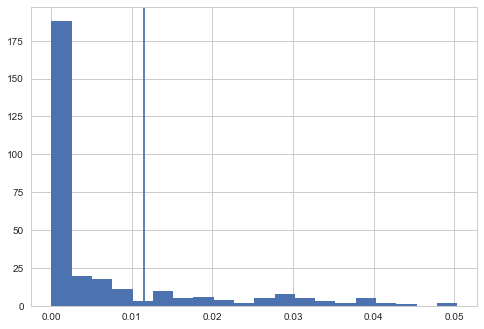

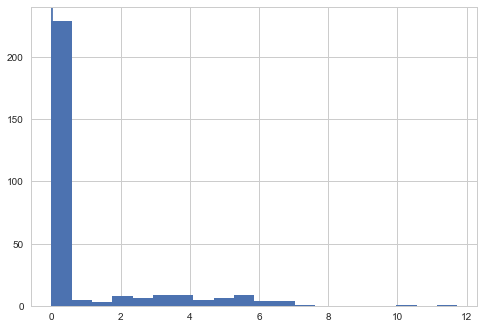

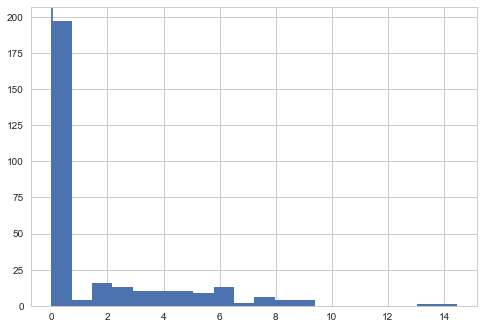

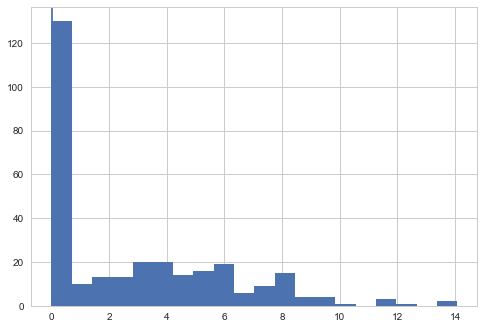

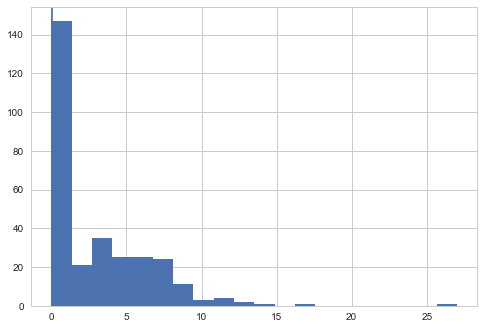

In [438]:
for i in range(5):
    plt.hist(regrets[:,i], bins=20)
    plt.axvline(fast_residual_term)
    plt.show()

# MOM version

In [13]:
# find median index
data = [0, 5, 3, 6, 23, 15, 19, 20, 19, 21]
data[numpy.argsort(data)[len(data)//2]]

19

In [34]:
regrets_MOM = []

n_replicate = 10

for i in tqdm(range(n_replicate)):
    X, y = make_gaussian_regression(n_samples, d, noise_sd)

    X_train, X_agg, X_test, y_train, y_agg, y_test = train_agg_test_split(X, y, 0.4, 0.3)

    predictors = make_function_class_regression()

    q = Q_aggregation(predictors)

    q.train_predictors(X_train, y_train)

    X_agg, y_agg = corrupt_dataset(X_agg, y_agg, prop_outliers=.25, corruption_type='constant')

    q.GMA_1_MOM(X_agg, y_agg, 30, 10)

    MSE_agg = mean_squared_error(q.predict(X_test), y_test)

    oracle_agg = np.min([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
    worst_agg = np.max([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
    regrets_MOM.append(MSE_agg - oracle_agg)

100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


In [20]:
regrets = []
for i in tqdm(range(n_replicate)):
    X, y = make_gaussian_regression(n_samples, d, noise_sd)

    X_train, X_agg, X_test, y_train, y_agg, y_test = train_agg_test_split(X, y, 0.4, 0.3)

    predictors = make_function_class_regression()

    q = Q_aggregation(predictors)

    q.train_predictors(X_train, y_train)

    X_agg, y_agg = corrupt_dataset(X_agg, y_agg, prop_outliers=.25, corruption_type='constant')

    q.GMA_1(X_agg, y_agg, 30)

    MSE_agg = mean_squared_error(q.predict(X_test), y_test)

    oracle_agg = np.min([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
    worst_agg = np.max([mean_squared_error(q.predictors[i].predict(X_test), y_test) for i in range(len(predictors))])
    regrets.append(MSE_agg - oracle_agg)

100%|██████████| 300/300 [40:21<00:00,  8.07s/it]


In [27]:
regrets_array = np.array([regrets, regrets_MOM]).T
df_2 = pd.DataFrame(regrets_array) 
df_2.columns = ["Q-aggregation", "MOM-Q-aggregation"]

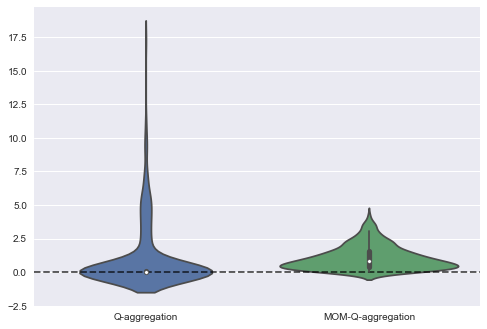

In [32]:
ax = sns.violinplot(data=df_2, shape='count')
ax.hlines(fast_residual_term, *ax.get_xlim(), alpha=0.7, color='black', linestyle='dashed', label='Optimal regret')

In [29]:
fast_residual_term = np.log(len(predictors))/y_agg.shape[0]
fast_residual_term

0.011552453009332421

In [ ]:
def newton_method(theta, B_star):
    